<a href="https://colab.research.google.com/github/ramjitampan/pyton_Ramzy/blob/main/Tugas3_Coding2_CitraDigital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip scikit-image


ERROR: unknown command "scikit-image"


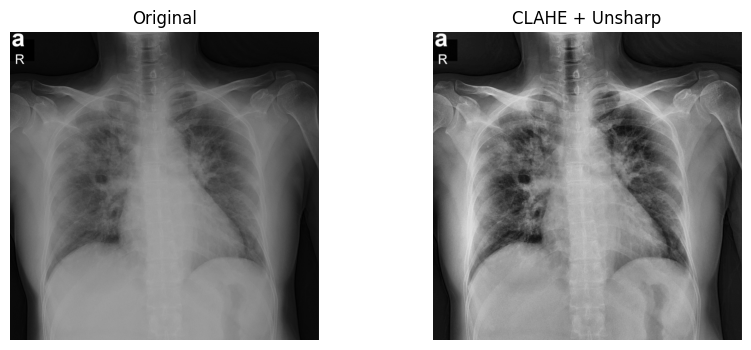

Hasil evaluasi xray1:
  gauss: PSNR=41.21, SSIM=0.978
  median: PSNR=45.46, SSIM=0.982
  clahe: PSNR=19.85, SSIM=0.893
  unsharp: PSNR=19.83, SSIM=0.869
  fft: PSNR=18.92, SSIM=0.685


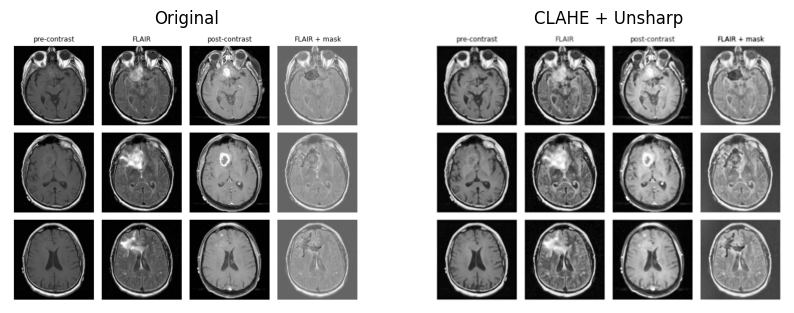

Hasil evaluasi mri1:
  gauss: PSNR=22.61, SSIM=0.864
  median: PSNR=27.25, SSIM=0.947
  clahe: PSNR=19.95, SSIM=0.802
  unsharp: PSNR=20.50, SSIM=0.824
  fft: PSNR=15.87, SSIM=0.529
Proses selesai. Hasil tersimpan di folder results/


In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# -------------------------
# Utility Functions
# -------------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def load_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Gambar tidak ditemukan: {path}")
    return img

def save_img(path, img):
    cv2.imwrite(path, img)

def show_compare(orig, processed, title1='Original', title2='Processed'):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(orig, cmap='gray'); plt.title(title1); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(processed, cmap='gray'); plt.title(title2); plt.axis('off')
    plt.show()

# -------------------------
# Enhancement Methods
# -------------------------
def clahe_equalize(img, clipLimit=2.0, tileGridSize=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    return clahe.apply(img)

def gaussian_denoise(img, ksize=(5, 5), sigma=1.0):
    return cv2.GaussianBlur(img, ksize, sigma)

def median_denoise(img, ksize=3):
    return cv2.medianBlur(img, ksize)

def unsharp_mask(img, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)
    sharpened = cv2.addWeighted(img, 1.0 + amount, blurred, -amount, 0)
    if threshold > 0:
        low_contrast_mask = np.abs(img - blurred) < threshold
        np.copyto(sharpened, img, where=low_contrast_mask)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

def fft_highpass_sharpen(img, radius=30, strength=1.5):
    h, w = img.shape
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    mask = ((Y - cy)**2 + (X - cx)**2) > (radius**2)

    fshift_hp = fshift * (1 + strength * mask)

    f_ishift = np.fft.ifftshift(fshift_hp)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.real(img_back)
    img_back = np.clip(img_back, 0, 255).astype(np.uint8)
    return img_back

# -------------------------
# Metrics
# -------------------------
def compute_metrics(orig, proc):
    psnr_val = psnr(orig, proc, data_range=255)
    ssim_val = ssim(orig, proc, data_range=255)
    return psnr_val, ssim_val

# -------------------------
# Main Pipeline
# -------------------------
def process_image(path_in, path_out_dir, basename):
    ensure_dir(path_out_dir)
    img = load_gray(path_in)
    save_img(os.path.join(path_out_dir, f"{basename}_orig.png"), img)

    # 1. Gaussian Filtering
    gauss = gaussian_denoise(img)
    save_img(os.path.join(path_out_dir, f"{basename}_gauss.png"), gauss)

    # 2. Median Filtering
    median = median_denoise(img)
    save_img(os.path.join(path_out_dir, f"{basename}_median.png"), median)

    # 3. CLAHE
    clahe = clahe_equalize(gauss)
    save_img(os.path.join(path_out_dir, f"{basename}_clahe.png"), clahe)

    # 4. Unsharp Mask
    sharp = unsharp_mask(clahe)
    save_img(os.path.join(path_out_dir, f"{basename}_unsharp.png"), sharp)

    # 5. FFT High-pass
    fft_sharp = fft_highpass_sharpen(clahe)
    save_img(os.path.join(path_out_dir, f"{basename}_fft.png"), fft_sharp)

    # Metrics
    metrics = {}
    for name, proc in [('gauss', gauss), ('median', median), ('clahe', clahe),
                       ('unsharp', sharp), ('fft', fft_sharp)]:
        p, s = compute_metrics(img, proc)
        metrics[name] = {"PSNR": p, "SSIM": s}

    # Visual Comparison (contoh)
    show_compare(img, sharp, "Original", "CLAHE + Unsharp")

    return metrics

# -------------------------
# Run Example
# -------------------------
if __name__ == "__main__":
    examples = [
        ("/content/1-s2.0-S0929664620300449-gr2_lrg-a.jpg", "results/xray", "xray1"),
        ("/content/example.png", "results/mri", "mri1"),
    ]
    summary = {}
    for src, outdir, name in examples:
        try:
            metrics = process_image(src, outdir, name)
            summary[name] = metrics
            print(f"Hasil evaluasi {name}:")
            for k, v in metrics.items():
                print(f"  {k}: PSNR={v['PSNR']:.2f}, SSIM={v['SSIM']:.3f}")
        except FileNotFoundError as e:
            print(e)

    # Simpan hasil metrik
    import json
    with open("results/summary_metrics.json", "w") as f:
        json.dump(summary, f, indent=2)
    print("Proses selesai. Hasil tersimpan di folder results/")